# CSX46 - Class Session 13 - Correlation network

In this class session we are going to analyze gene expression data from a human bladder cancer cohort, using python. We will load a data matrix of expression measurements of 4,473 genes in 414 different bladder cancer samples. These genes have been selected because they are differentially expressed between normal bladder and bladder cancer (thus more likely to have a function in bladder cancer specifically), but the columns in the data matrix are restricted to bladder cancer samples (not normal bladder) because we want to obtain a network representing variation across cancers. The measurements in the matrix have already been normalized to account for inter-sample heterogeneity and then log2 transformed. Our job is to compute Pearson correlation coefficients between all pairs of genes, obtain Fisher-transformed *z*-scores for all pairs of genes, test each pair of genes for significance of the *z* score, adjust for multiple hypothesis testing, filter to eliminate any pair for which *R* < 0.75 or *P*adj > 0.01, load the graph into an `igraph.Graph` object, and plot the degree distribution on log-log scale. We will then answer two questions: (1) does the network look to be scale-free? and (2) what is it's best-fit scaling exponent?

For this notebook, we will need `pandas`, `numpy`, `scipy.stats`, `matplotlib`, `pylab`, `statsmodels.sandbox.stats.multicomp`, `pycairo`, `igraph`, and `math`

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats, pylab, math
import statsmodels.sandbox.stats.multicomp
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo
import cairo
!pip install python-igraph
import igraph

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgif-dev is already the newest version (5.1.9-2build2).
libgif-dev set to manually installed.
libjpeg-dev is already the newest version (8c-2ubuntu10).
libjpeg-dev set to manually installed.
The following additional packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libffi-dev libglib2.0-dev libglib2.0-dev-bin libice-dev
  liblzo2-2 libmount-dev libpixman-1-dev libselinux1-dev libsepol-dev libsm-dev libxcb-render0-dev
  libxcb-shm0-dev
Suggested packages:
  libcairo2-doc libgirepository1.0-dev libglib2.0-doc libgdk-pixbuf2.0-bin | libgdk-pixbuf2.0-dev
  libxml2-utils libice-doc libsm-doc
The following NEW packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libcairo2-dev libffi-dev libglib2.0-dev
  libglib2.0-dev-bin libice-dev liblzo2-2 libmount-dev libpixman-1-dev libselinux1-dev libsepol-dev
  libsm-dev libxcb-render0-dev libxcb-shm0-dev
0 upgrad

Download the file https://csx46.s3-us-west-2.amazonaws.com/bladder_cancer_genes_tcga.txt to the local file `bladder_cancer_genes_tcga.txt`

In [ ]:
!curl https://csx46.s3-us-west-2.amazonaws.com/bladder_cancer_genes_tcga.txt > bladder_cancer_genes_tcga.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29.9M  100 29.9M    0     0  19.5M      0  0:00:01  0:00:01 --:--:-- 19.5M


Using `pandas.read_csv`, load the tab-deliminted text file of gene expression measurements (rows correspond to genes, columns correspond to bladder tumor samples), into a data frame `gene_matrix_for_network_df`.

In [ ]:
gene_matrix_for_network_df = pd.read_csv("bladder_cancer_genes_tcga.txt", sep="\t")

Use the `pandas.DataFrame.values` attribute to make a matrix `gene_matrix_for_network`. Print out the dimensions of the matrix, by accessing its `shape` variable

In [ ]:
gene_matrix_for_network = gene_matrix_for_network_df.values
gene_matrix_for_network.shape

(4473, 414)

Use `del` to delete the data frame, since we no longer need it (save memory)

In [ ]:
del gene_matrix_for_network_df

Look at the online help for the `numpy.corrcoef` function, using `help(np.corrcoef)`.  When you pass a single argument `x` which is a 2D "array" (i.e., a matrix), by default does `corrcoef` compute coefficients for pairs of rows, or pairs of columns?

In [ ]:
help(np.corrcoef)

Help on _ArrayFunctionDispatcher in module numpy:

corrcoef(x, y=None, rowvar=True, bias=<no value>, ddof=<no value>, *, dtype=None)
    Return Pearson product-moment correlation coefficients.
    
    Please refer to the documentation for `cov` for more detail.  The
    relationship between the correlation coefficient matrix, `R`, and the
    covariance matrix, `C`, is
    
    .. math:: R_{ij} = \frac{ C_{ij} } { \sqrt{ C_{ii} C_{jj} } }
    
    The values of `R` are between -1 and 1, inclusive.
    
    Parameters
    ----------
    x : array_like
        A 1-D or 2-D array containing multiple variables and observations.
        Each row of `x` represents a variable, and each column a single
        observation of all those variables. Also see `rowvar` below.
    y : array_like, optional
        An additional set of variables and observations. `y` has the same
        shape as `x`.
    rowvar : bool, optional
        If `rowvar` is True (default), then each row represents a
       

Compute the 4,473 x 4,473 matrix of gene-gene Pearson correlation coefficients, using `numpy.corrcoef` (this function treats each row as a variable, so you don't have to do any transposing of the matrix, unlike the situation in R).

In [ ]:
gene_matrix_for_network_cor = np.corrcoef(gene_matrix_for_network)

Look at the online help for `numpy.fill_diagonal`.  Does it return the modified matrix or modify the matrix argument in place?

In [ ]:
help(np.fill_diagonal)

Help on _ArrayFunctionDispatcher in module numpy:

fill_diagonal(a, val, wrap=False)
    Fill the main diagonal of the given array of any dimensionality.
    
    For an array `a` with ``a.ndim >= 2``, the diagonal is the list of
    locations with indices ``a[i, ..., i]`` all identical. This function
    modifies the input array in-place, it does not return a value.
    
    Parameters
    ----------
    a : array, at least 2-D.
      Array whose diagonal is to be filled, it gets modified in-place.
    
    val : scalar or array_like
      Value(s) to write on the diagonal. If `val` is scalar, the value is
      written along the diagonal. If array-like, the flattened `val` is
      written along the diagonal, repeating if necessary to fill all
      diagonal entries.
    
    wrap : bool
      For tall matrices in NumPy version up to 1.6.2, the
      diagonal "wrapped" after N columns. You can have this behavior
      with this option. This affects only tall matrices.
    
    See al

Set the diagonal elements of the matrix to zero, using `numpy.fill_diagonal`

In [ ]:
np.fill_diagonal(gene_matrix_for_network_cor, 0)

Look at the online help for `numpy.multiply`.  Does it do element-wise multiplication or matrix multiplication?

In [ ]:
help(np.multiply)

Help on ufunc:

multiply = <ufunc 'multiply'>
    multiply(x1, x2, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])
    
    Multiply arguments element-wise.
    
    Parameters
    ----------
    x1, x2 : array_like
        Input arrays to be multiplied.
        If ``x1.shape != x2.shape``, they must be broadcastable to a common
        shape (which becomes the shape of the output).
    out : ndarray, None, or tuple of ndarray and None, optional
        A location into which the result is stored. If provided, it must have
        a shape that the inputs broadcast to. If not provided or None,
        a freshly-allocated array is returned. A tuple (possible only as a
        keyword argument) must have length equal to the number of outputs.
    where : array_like, optional
        This condition is broadcast over the input. At locations where the
        condition is True, the `out` array will be set to the ufunc result.
        El

Look at the online help for `numpy.tri`.  Does it modify a matrix argument in-place or return a matrix?  What is in the matrix that it returns?

In [ ]:
help(np.tri)

Help on function tri in module numpy:

tri(N, M=None, k=0, dtype=<class 'float'>, *, like=None)
    An array with ones at and below the given diagonal and zeros elsewhere.
    
    Parameters
    ----------
    N : int
        Number of rows in the array.
    M : int, optional
        Number of columns in the array.
        By default, `M` is taken equal to `N`.
    k : int, optional
        The sub-diagonal at and below which the array is filled.
        `k` = 0 is the main diagonal, while `k` < 0 is below it,
        and `k` > 0 is above.  The default is 0.
    dtype : dtype, optional
        Data type of the returned array.  The default is float.
    like : array_like, optional
        Reference object to allow the creation of arrays which are not
        NumPy arrays. If an array-like passed in as ``like`` supports
        the ``__array_function__`` protocol, the result will be defined
        by it. In this case, it ensures the creation of an array object
        compatible with t

Set the upper-triangle of the matrix to zero, using `numpy.multiply` and `numpy.tri` (for `numpy.tri`, you will want to use the single-asterisk argument syntax):

In [ ]:
gene_matrix_for_network_cor = np.multiply(gene_matrix_for_network_cor,
                                          np.tri(*gene_matrix_for_network_cor.shape))

Using `numpy.where`, get a tuple of two numpy.arrays containing the row/col indices of the entries of the matrix for which *R* >= 0.75. Use array indexing to obtain the *R* values for these matrix entries, as a numpy array `cor_coeff_values_above_thresh`.

In [ ]:
inds_correl_above_thresh = np.where(gene_matrix_for_network_cor >= 0.75)
cor_coeff_values_above_thresh = gene_matrix_for_network_cor[inds_correl_above_thresh]

Refer to Eq. (13.5) in the assigned readding for today's class (p9 of the PDF).  Obtain a numpy array of the correlation coefficients that exceeded 0.75, and Fisher-transform the correlation coefficient values to get a vector `z_scores` of *z* scores. Each of these *z* scores will correspond to an **edge** in the network, unless the absolute *z* score is too small such that we can't exclude the null hypothesis that the corresponding two genes' expression values are indepdenent (we will perform that check in the next step).

In [ ]:
z_scores = 0.5*np.log((1 + cor_coeff_values_above_thresh)/
                      (1 - cor_coeff_values_above_thresh))

Delete the correlation matrix object in order to save memory (we won't need it from here on out).

In [ ]:
del gene_matrix_for_network_cor

Assume that under the null hypothesis that two genes are independent, then sqrt(M-3)z for the pair of genes is an independent sample from the normal distribution with zero mean and unit variance, where M is the number of samples used to compute the Pearson correlation coefficient (i.e., M = 414). For each entry in `z_scores` compute a *P* value as the area under two tails of the normal distribution N(x),  where the two tails are x < -sqrt(M-3)z and x > sqrt(M-3)z. (You'll know you are doing it right if z=0 means you get a P value of 1).  You will want to use the functions `numpy.abs` and `scipy.stats.norm.cdf`, as well as the `math.sqrt` function (in order to compute the square root).

In [ ]:
gene_matrix_for_network.shape

(4473, 414)

In [ ]:
M = gene_matrix_for_network.shape[1]
P_values = 2*scipy.stats.norm.cdf(-np.abs(z_scores)*math.sqrt(M-3))

Adjust the P values for multiple hypothesis testing, using the `statsmodels.sandbox.stats.multicomp.multipletests` function wth `method="fdr_bh"`

In [ ]:
P_values_adj = statsmodels.sandbox.stats.multicomp.multipletests(P_values,
                                                                 method="fdr_bh")[1]

Verify that we don't need to drop any entries due to the adjusted P value not being small enough (use `numpy.where` and `len`); this should produce zero since we have M=414 samples per gene.

In [ ]:
len(np.where(P_values_adj >= 0.01)[0])

0

Read the online help for the function `zip`.  What does it do?

In [ ]:
help(zip)

Help on class zip in module builtins:

class zip(object)
 |  zip(*iterables, strict=False) --> Yield tuples until an input is exhausted.
 |  
 |     >>> list(zip('abcdefg', range(3), range(4)))
 |     [('a', 0, 0), ('b', 1, 1), ('c', 2, 2)]
 |  
 |  The zip object yields n-length tuples, where n is the number of iterables
 |  passed as positional arguments to zip().  The i-th element in every tuple
 |  comes from the i-th iterable argument to zip().  This continues until the
 |  shortest argument is exhausted.
 |  
 |  If strict is true and one of the arguments is exhausted before the others,
 |  raise a ValueError.
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __next__(self, /)
 |      Implement next(self).
 |  
 |  __reduce__(...)
 |      Return state information for pickling.
 |  
 |  __setstate__(...)
 |      Set state information for unpickling.
 |  
 |  

We want to pass our tuple of numpy arrays containing row and column indices to `Graph.TupleList`; however, `Graph.TupleList` accepts a tuple list, not a tuple of numpy arrays. So we need to make a tuple list, using `zip`:

In [ ]:
row_col_inds_tuple_list = list(zip(inds_correl_above_thresh[0],
                                   inds_correl_above_thresh[1]))

## [note this can be done more elegantly using the unary "*" operator:
##    row_col_inds_tuple_list = list(zip(*inds_correl_above_thresh))
##  see how we only need to type the variable name once, if we use the unary "*" ]

Make an undirected graph from the row/column indices of the (upper-triangle) gene pairs whose  correlations were above our threshold, using `igraph.Graph.TupleList`. Print a summary of the network, as a sanity check, using the `igraph.Graph.summary` method.

Take a look at the first ten entries of `row_col_inds_tuple_list`

In [ ]:
row_col_inds_tuple_list[0:9]

[(2, 0),
 (8, 1),
 (10, 9),
 (11, 0),
 (11, 2),
 (12, 0),
 (12, 2),
 (15, 2),
 (15, 12)]

Make an `igraph.Graph` object called `final_network`, by passing `row_col_inds_tuple_list` to the class method `igraph.Graph.TupleList`. As usual, print the graph summary using `igraph.Graph.summary`.

In [ ]:
final_network = igraph.Graph.TupleList(row_col_inds_tuple_list)
final_network.summary()

'IGRAPH UN-- 1394 9916 -- \n+ attr: name (v)'

Plot the degree distribution on log-log scale; does it appear to be scale-free?

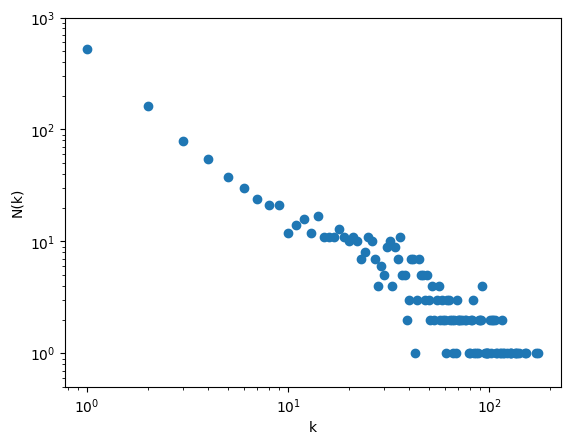

In [ ]:
degree_dist = final_network.degree_distribution()
xs, ys = zip(*[(left, count) for left, _, count in degree_dist.bins()])
plt.scatter(xs, ys, marker="o")
ax = plt.gca()
ax.set_yscale("log")
ax.set_xscale("log")
plt.ylim((0.5,1000))
pylab.xlabel("k")
pylab.ylabel("N(k)")
pylab.show()

Use the `igraph.statistics.power_law_fit` function to estimate the scaling exponent *alpha* of the degree distribution:

In [ ]:
igraph.statistics.power_law_fit(final_network.degree()).alpha

1.511938976892833

Run the `community_walktrap()` method on the `final_network` object to cluster the vertices, and assign the resulting `igraph.clustering.VertexDendogram` object to variable `comm_res`.

In [ ]:
comm_res = final_network.community_walktrap()

Plot the dendrogram `comm_res` using `igraph.drawing.plot`

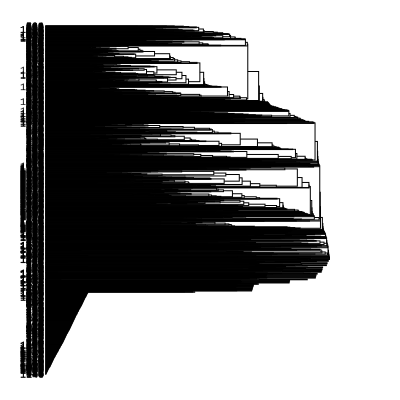

In [ ]:
igraph.drawing.plot(comm_res, bbox=[0,0,400,400])

Use `sorted` (with `reverse=True`) and the `as_clustering()` and `sizes()` methods (chained) to examine sizes of the 20 largest clusters.

In [ ]:
sorted(comm_res.as_clustering().sizes(), reverse=True)[0:20]

[392, 209, 147, 29, 9, 9, 8, 7, 7, 7, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5]

## extra challenge:
If you got this far, see if you can scatter plot the relationship between R (as the independent variable) and -log10(P) value (as the dependent variable).  When the effect size variable (e.g., *R*) can range from negative to positive, this plot is sometimes called a "volcano plot".

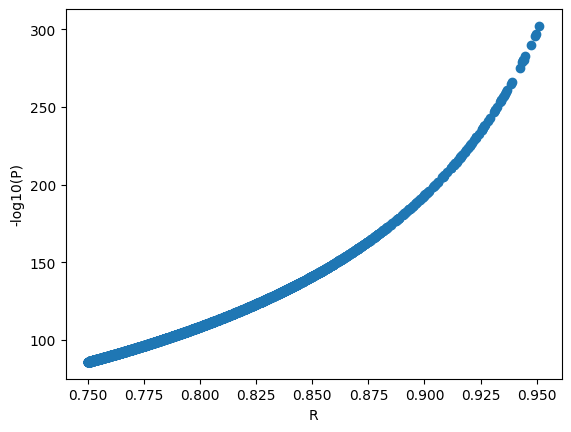

In [ ]:
inds_use = np.where(P_values_adj > 0)
plt.scatter(cor_coeff_values_above_thresh[inds_use],
            -np.log10(P_values_adj[inds_use]))
pylab.xlabel("R")
pylab.ylabel("-log10(P)")
pylab.show()

## extra-extra challenge
For each of the gene pairs for which *R*&nbsp;>&nbsp;0.75, see if you can compute the *t*-test *P*-value for each correlation coefficient (don't bother adjusting for false discovery rate control).  Compare to the (un-adjusted) *P*-values that you got using the Fisher transformation, using a scatter plot.  How do they compare?  Which test has better statistical power, for this case where *M*&nbsp;=&nbsp;414? (If you are wondering, *general* advice is to use Fisher if *M*&nbsp;&geq;&nbsp;10; for very small numbers of samples, use Student's *t*-test).

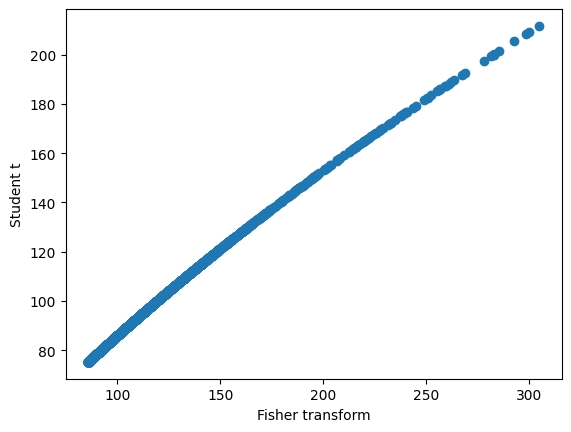

In [ ]:
ts = np.divide(cor_coeff_values_above_thresh * math.sqrt(M - 2),
               np.sqrt(1 - cor_coeff_values_above_thresh**2))
P_values_studentT = 2*scipy.stats.t.cdf(-ts, M-2)
inds_use = np.where(np.logical_and(P_values > 0, P_values_studentT > 0))
plt.scatter(-np.log10(P_values[inds_use]),
            -np.log10(P_values_studentT[inds_use]))
pylab.xlabel("Fisher transform")
pylab.ylabel("Student t")
pylab.show()